In [1]:
# Prerequisites
import pandas as pd
from pathlib import Path
from infowater.output.manager import Manager as OutMan
import arcpy
import matplotlib.pyplot as plt
%matplotlib inline


# Define Project information. Input new project name (.aprx), Scenario, and vdb and iwp_working folders as necessary
project_name = "Purpletown_Python"
scenario1 = "Base"
vdb_folder = "IWVDB2" # You can find this by viewing the Data Source tab on properties of your map layers
iwp_working_folder = "C:\ProgramData\Innovyze\Temp\IWPR10VDB"

In [2]:
# Create list of Junction ID's in Domain

junction_table = iwp_working_folder + "\\" + vdb_folder + "\\Map\\Map.gdb\\Junction"

# Create a list of junction ID's in Domain
cursor = arcpy.da.SearchCursor(junction_table, ["MOID"], "MOTYPE=1")
domain_junctions = []
for row in cursor:
    domain_junctions.append(row[0])

print(domain_junctions)

['J24', 'J548', 'J580', 'J722', 'J924', 'J1160']


In [3]:
# We must create the Data Frame object to include in the Seaborn graph
# Use above domain list to generate custom output table

# Get Outputs
aprx = arcpy.mp.ArcGISProject("CURRENT")
project_path = Path(aprx.filePath).parent
out1_path = str(project_path) + "/" + project_name + ".OUT/SCENARIO/" + scenario1 + "/HYDQUA.OUT"
out1 = OutMan(out1_path)

# Get list of indices based on selected junction ID's
junctions = out1.get_element_list("Junction")
j_indices = [i for i, moid in enumerate(junctions) if moid in domain_junctions]

# Create list of Junction ID's in Selection Set

rows = []
time = out1.get_time_list()
for id in domain_junctions:
    pressure = out1.get_time_data("junction", id, "pressure")
    rows.extend([[id, time [i], pressure[i]*0.433] for i in range(len(time))])
 
df = pd.DataFrame(rows, columns=['ID', 'Time (hr)','Pressure (psi)'])
df2=df
dftable=df
print(df)


          ID  Time (hr)  Pressure (psi)
0        J24       0.00       98.731188
1        J24       0.25       98.748948
2        J24       0.50       98.740068
3        J24       0.75       98.748948
4        J24       1.00       98.757617
...      ...        ...             ...
17281  J1160     719.00       81.731320
17282  J1160     719.25       81.731320
17283  J1160     719.50       81.767474
17284  J1160     719.75       81.790519
17285  J1160     720.00       81.914203

[17286 rows x 3 columns]


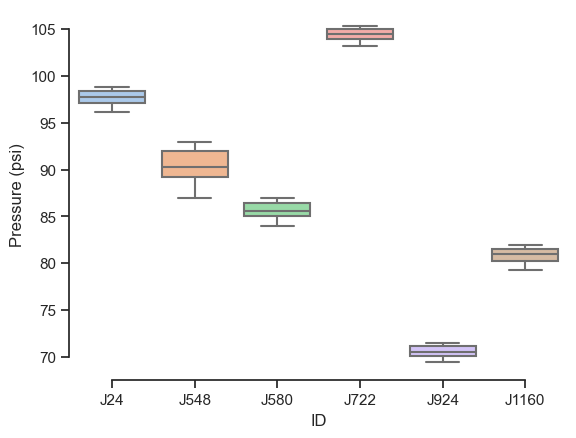

In [4]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="ticks", palette="pastel")

# Draw a boxplot to show pressure range by junction
sns.boxplot(x="ID", y="Pressure (psi)", data=df)
sns.despine(offset=1, trim=True)

# Show the plot
plt.show()

In [5]:
import numpy as np

# Load your existing DataFrame
df2 = df

# Convert the dbf table into a NumPy array

arr = arcpy.da.TableToNumPyArray(iwp_working_folder + "\\" + vdb_folder + "\\Junction.DBF", ["ID","ZONEID"])

# Convert the NumPy array into a pandas DataFrame
dbf_df = pd.DataFrame(arr)

# Merge the two DataFrames based on the join column
df2 = pd.merge(df, dbf_df, left_on="ID", right_on="ID",how="left")

print(dbf_df)
print(df2)

       ID ZONEID
0     J10   PZM3
1     J12   PZM3
2     J14   PZM3
3     J16   PZM1
4     J18   PZM1
..    ...    ...
712  8478   PZM1
713  8480   PZM1
714  8482   PZM3
715  8484   PZM5
716  8486   PZM4

[717 rows x 2 columns]
          ID  Time (hr)  Pressure (psi) ZONEID
0        J24       0.00       98.731188   PZM1
1        J24       0.25       98.748948   PZM1
2        J24       0.50       98.740068   PZM1
3        J24       0.75       98.748948   PZM1
4        J24       1.00       98.757617   PZM1
...      ...        ...             ...    ...
17281  J1160     719.00       81.731320   PZM1
17282  J1160     719.25       81.731320   PZM1
17283  J1160     719.50       81.767474   PZM1
17284  J1160     719.75       81.790519   PZM1
17285  J1160     720.00       81.914203   PZM1

[17286 rows x 4 columns]


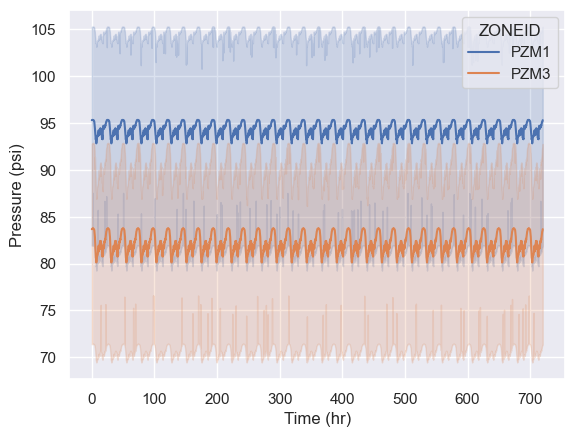

In [6]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="Time (hr)", y="Pressure (psi)",
             hue="ZONEID",
             data=df2)
# Save and show the plot
plt.savefig('D:\InfoWater Pro_Python\Pressure_w_ErrorBounds.png', dpi = 400)
plt.show()


In [7]:
# Get remaining results to build table
p1min = out1.get_range_data("Junction", "Pressure", "min")
p1avg = out1.get_range_data("Junction", "Pressure", "avg")
dmd1avg = out1.get_range_data("Junction", "Demand", "avg")

# Generate table
dftable = pd.DataFrame(
{
    "Junction": [junctions[i] for i in j_indices],
    "Base Avg Demand (gpm)": [dmd1avg[i]*448.8 for i in j_indices],
    "Base Avg Pressure (psi)": [p1avg[i]*0.433 for i in j_indices],
    "Base min Pressure (psi)": [p1min[i]*0.433 for i in j_indices],
})

dftable.sort_values(by='Base Avg Demand (gpm)',ascending=False)
df.to_excel('D:\InfoWater Pro_Python\Junction_report.xlsx')